In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# SEIS Model

### Euler's method: Solution to deterministic model, i.e. numerical solution to differential eq.

In [77]:
# --- Denmark COVID-19 scenario -------------------------------
# SEIS exaggerates reinfections and produces a single gigantic wave
beta    = 0.33 
gamma   = 0.14
epsilon = 0.196

S0 = 5_826_529             # susceptibles
E0 = 1_000                 # exposed
I0 = 500                   # infectious
days = 200                 # simulate time

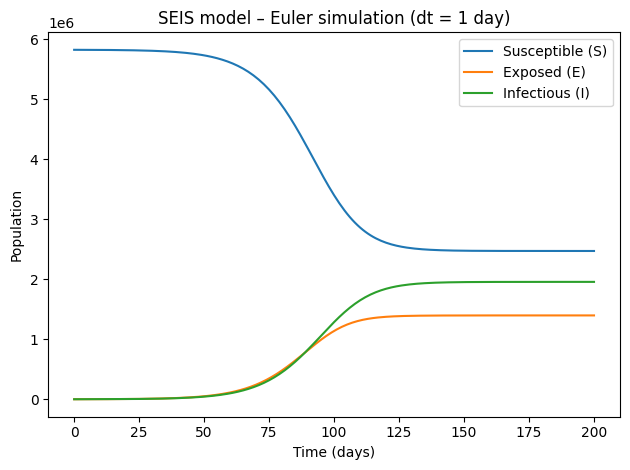

In [78]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_seis_euler(beta: float,
                  gamma: float,
                  epsilon: float,
                  S0: float,
                  E0: float,
                  I0: float,
                  days: int,
                  dt: float = 1.0):
    """
    Euler-method simulation of the SEIS epidemic model.

    Parameters
    ----------
    beta      : transmission rate
    gamma     : recovery rate
    epsilon   : incubation infectious rate
    S0, E0, I0: initial population counts
    days      : number of days to simulate
    dt        : time step (default = 1 day)

    Returns
    -------
    t : ndarray, simulation time points
    S : ndarray, susceptibles over time
    E : ndarray, exposed over time
    I : ndarray, infectious over time
    """
    steps = int(days / dt)
    t = np.arange(steps + 1) * dt

    S = np.empty(steps + 1, dtype=float)
    E = np.empty(steps + 1, dtype=float)
    I = np.empty(steps + 1, dtype=float)

    # initial conditions
    S[0], E[0], I[0] = S0, E0, I0
    N = S0 + E0 + I0   # total population (assumed constant)

    # Euler forward integration
    for k in range(steps):
        dS = (-beta * S[k] * I[k] / N) + gamma * I[k]
        dE =  (beta * S[k] * I[k] / N) - epsilon * E[k]
        dI =  (epsilon * E[k]) - gamma * I[k]

        S[k + 1] = S[k] + dS * dt
        E[k + 1] = E[k] + dE * dt
        I[k + 1] = I[k] + dI * dt

    return t, S, E, I



t, S, E, I = simulate_seis_euler(beta, gamma, epsilon, S0, E0, I0, days)

# Plot results
plt.figure()
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, E, label="Exposed (E)")
plt.plot(t, I, label="Infectious (I)")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIS model – Euler simulation (dt = 1 day)")
plt.legend()
plt.tight_layout()
plt.show()


### Play with constants:

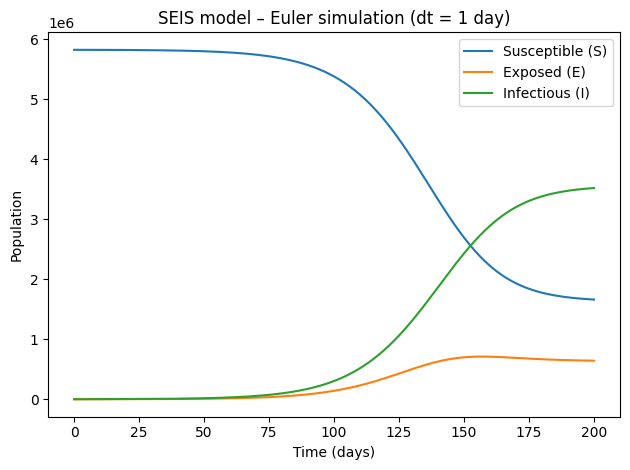

In [79]:

# --- Denmark COVID-19 scenario -------------------------------
beta    = 0.125        # from dataset
gamma   = 0.035       # from dataset
epsilon = 1/5.1            # 1 / 5.1-day incubation

S0 = 5_826_529             # susceptibles
E0 = 1_000                 # exposed
I0 = 500                   # infectious
days = 200                 # simulate ~ 5 months


t, S, E, I = simulate_seis_euler(beta, gamma, epsilon, S0, E0, I0, days)

# Plot results
plt.figure()
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, E, label="Exposed (E)")
plt.plot(t, I, label="Infectious (I)")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIS model – Euler simulation (dt = 1 day)")
plt.legend()
plt.tight_layout()
plt.show()

### Stochastic version

In [80]:
# --- Denmark COVID-19 scenario -------------------------------
beta    = 0.33 
gamma   = 0.14
epsilon = 0.196

S0 = 5_826_529             # susceptibles
E0 = 1_000                 # exposed
I0 = 500                   # infectious
days = 200                 # simulate time
N = S0 + E0 + I0   # total population (assumed constant)

In [81]:
#  Stochastic SEIS simulation (daily Binomial step)
def simulate_seis(S0, E0, I0, *, beta, epsilon, gamma,
                  N, days):
    """
    Simulate one SEIS trajectory.

    Returns
    -------
    S, E, I : ndarray (length = days + 1)
    """
    S = np.empty(days + 1, dtype=int)
    E = np.empty_like(S)
    I = np.empty_like(S)

    S[0], E[0], I[0] = S0, E0, I0

    for t in range(days):
        rng = np.random.default_rng()
        s, e, i = S[t], E[t], I[t]

        # daily per-person probabilities
        p_SE = 1.0 - np.exp(-beta * i / N) # infection  S → E
        p_EI = 1.0 - np.exp(-epsilon) # incubation E → I
        p_IS = 1.0 - np.exp(-gamma) # recovery   I → S

        # Binomial draws
        X_SE = rng.binomial(s, p_SE)
        X_EI = rng.binomial(e, p_EI)
        X_IS = rng.binomial(i, p_IS)

        # compartment updates
        S[t + 1] = s - X_SE + X_IS
        E[t + 1] = e + X_SE - X_EI
        I[t + 1] = i + X_EI - X_IS

    return S, E, I

def mean_ci(arr, alpha=95):
    """mean and CI."""
    mean  = arr.mean(axis=0)
    lower = np.percentile(arr, (100 - alpha) / 2, axis=0)
    upper = np.percentile(arr, 100 - (100 - alpha) / 2, axis=0)
    return mean, lower, upper

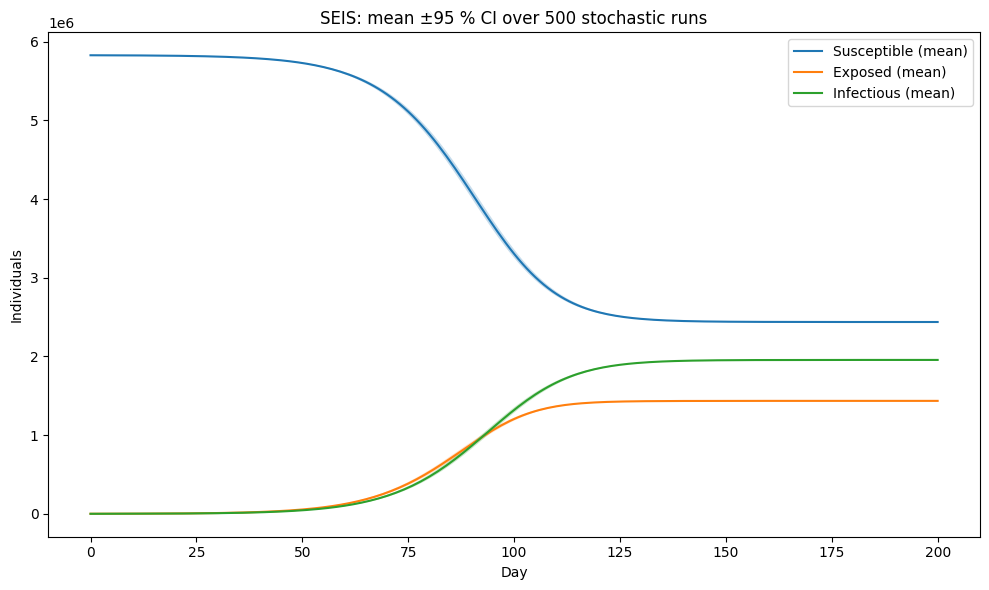

In [82]:
n_runs  = 500      # number of replicates
S_runs = np.empty((n_runs, days + 1), dtype=int)
E_runs = np.empty_like(S_runs)
I_runs = np.empty_like(S_runs)


for r in range(n_runs):
    S_traj, E_traj, I_traj = simulate_seis(
        S0, E0, I0,
        beta=beta, epsilon=epsilon, gamma=gamma,
        N = N, days=days
    )
    S_runs[r] = S_traj
    E_runs[r] = E_traj
    I_runs[r] = I_traj



S_mean, S_low, S_high = mean_ci(S_runs)
E_mean, E_low, E_high = mean_ci(E_runs)
I_mean, I_low, I_high = mean_ci(I_runs)
t = np.arange(days + 1)



plt.figure(figsize=(10, 6))
plt.plot(t, S_mean, label="Susceptible (mean)")
plt.fill_between(t, S_low, S_high, alpha=0.25)
plt.plot(t, E_mean, label="Exposed (mean)")
plt.fill_between(t, E_low, E_high, alpha=0.25)
plt.plot(t, I_mean, label="Infectious (mean)")
plt.fill_between(t, I_low, I_high, alpha=0.25)
plt.xlabel("Day")
plt.ylabel("Individuals")
plt.title(f"SEIS: mean ±95 % CI over {n_runs} stochastic runs")
plt.legend()
plt.tight_layout()
plt.show()


### Different resolution

In [83]:
beta    = 0.14 
gamma   = 0.014
epsilon = 0.196

S0 = 1000             # susceptibles
E0 = 200                 # exposed
I0 = 50                   # infectious
days = 200                 # simulate time
N = S0 + E0 + I0   # total population (assumed constant)

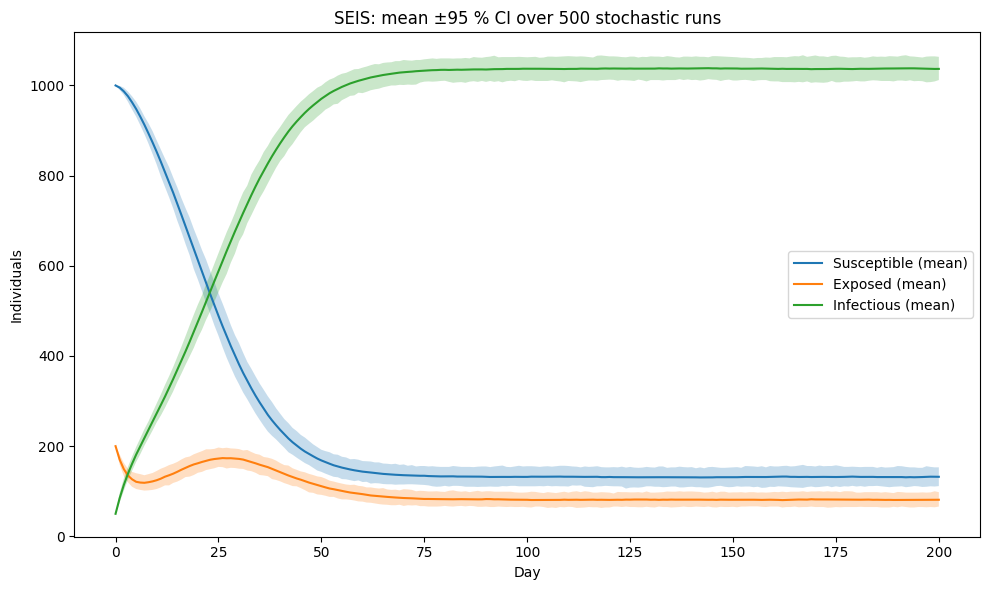

In [84]:
n_runs  = 500      # number of replicates
S_runs = np.empty((n_runs, days + 1), dtype=int)
E_runs = np.empty_like(S_runs)
I_runs = np.empty_like(S_runs)


for r in range(n_runs):
    S_traj, E_traj, I_traj = simulate_seis(
        S0, E0, I0,
        beta=beta, epsilon=epsilon, gamma=gamma,
        N = N, days=days
    )
    S_runs[r] = S_traj
    E_runs[r] = E_traj
    I_runs[r] = I_traj



S_mean, S_low, S_high = mean_ci(S_runs)
E_mean, E_low, E_high = mean_ci(E_runs)
I_mean, I_low, I_high = mean_ci(I_runs)
t = np.arange(days + 1)



plt.figure(figsize=(10, 6))
plt.plot(t, S_mean, label="Susceptible (mean)")
plt.fill_between(t, S_low, S_high, alpha=0.25)
plt.plot(t, E_mean, label="Exposed (mean)")
plt.fill_between(t, E_low, E_high, alpha=0.25)
plt.plot(t, I_mean, label="Infectious (mean)")
plt.fill_between(t, I_low, I_high, alpha=0.25)
plt.xlabel("Day")
plt.ylabel("Individuals")
plt.title(f"SEIS: mean ±95 % CI over {n_runs} stochastic runs")
plt.legend()
plt.tight_layout()
plt.show()

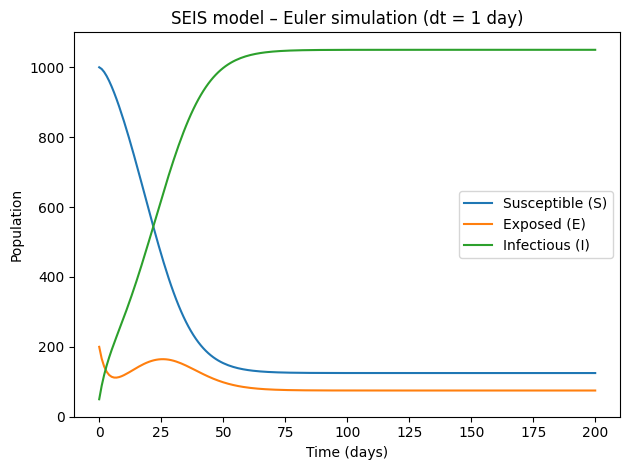

In [85]:
t, S, E, I = simulate_seis_euler(beta, gamma, epsilon, S0, E0, I0, days)

# Plot results
plt.figure()
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, E, label="Exposed (E)")
plt.plot(t, I, label="Infectious (I)")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIS model – Euler simulation (dt = 1 day)")
plt.legend()
plt.tight_layout()
plt.show()